In [ ]:
#Import the necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Connect to GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Set-up constants
data_dir = '/content/drive/MyDrive/Colab Notebooks/Preprocessed_Images'
BATCH_SIZE = 64
IMG_SIZE = (224, 224)
EPOCHS = 80

In [ ]:
#Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
        layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
    ]
)

#Create the model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    #Image augmentation block
    x = data_augmentation(inputs)

    #Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  #Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        #Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  #Add back residual
        previous_block_activation = x  #Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_6 (Sequential)      (None, 224, 224, 3)  0           ['input_7[0][0]']                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 224, 224, 3)  0           ['sequential_6[0][0]']           
                                                                                                  
 conv2d_36 (Conv2D)             (None, 112, 112, 32  896         ['rescaling_6[0][0]']      

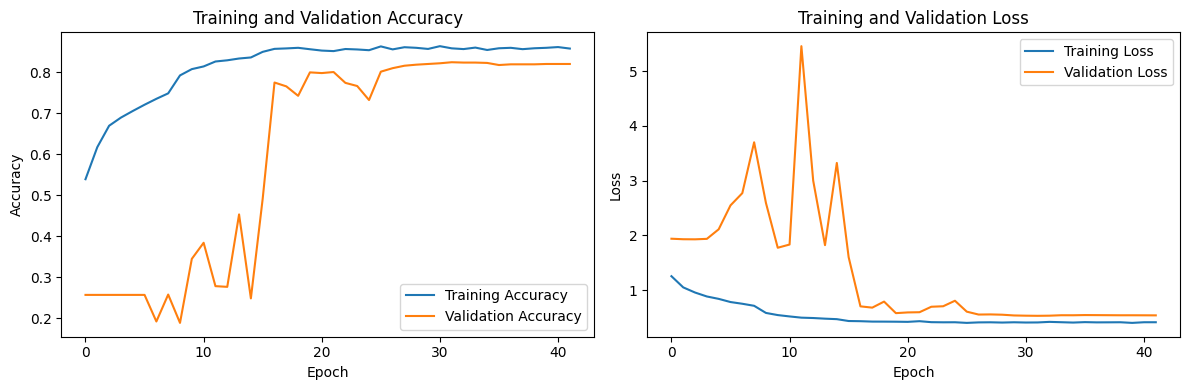

In [ ]:
model = make_model(input_shape=IMG_SIZE + (3,), num_classes=7)
model.summary()

#Compile the model
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

#Load datasets
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

val_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

#Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
    ]
)


#Save the model
model.save('/content/drive/MyDrive/Colab Notebooks/initial_model_sierra.h5')

#Evaluate on the test set
test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

#Plot training history
import matplotlib.pyplot as plt

#Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

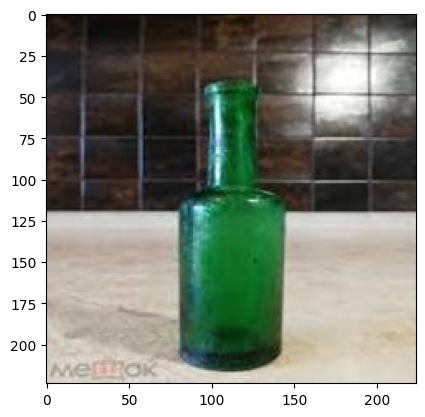

1/1 [==============================] - 1s 602ms/step
Predicted class index: 3
Predicted class name: glass


In [ ]:
#After training

#Get class labels
class_labels = {v: k for k, v in train_generator.class_indices.items()}

#Libraries for manual testing:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

#Load the model
model = load_model("/content/drive/MyDrive/Colab Notebooks/initial_model_sierra.h5")

#Image path
image_path = "/content/drive/MyDrive/Colab Notebooks/Preprocessed_Images/glass/glass_0042.jpg"

#Load image
img = image.load_img(image_path, target_size=(224, 224))

#Display image
plt.imshow(img)
plt.show()

#Convert image to a numpy array
x = image.img_to_array(img)

#Add a fourth dimension
x = np.expand_dims(x, axis=0)

#Scale the input image
x = x / 255.0

#Make a prediction
predictions = model.predict(x)

#Get the predicted class index
predicted_class = np.argmax(predictions[0])

#Map the predicted class index to the class label
predicted_class_name = class_labels[predicted_class]

#Print results
print("Predicted class index:", predicted_class)
print("Predicted class name:", predicted_class_name)


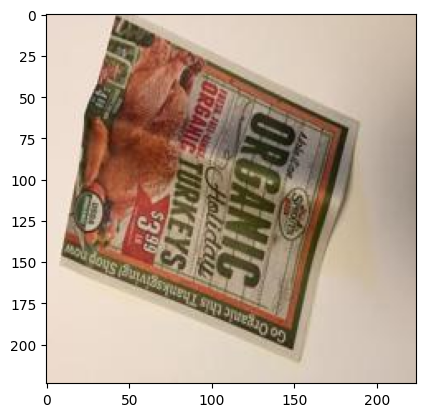

1/1 [==============================] - 0s 25ms/step
Predicted class index: 5
Predicted class name: paper


In [ ]:

#New image path
image_path = "/content/drive/MyDrive/Colab Notebooks/Preprocessed_Images/paper/paper_0008.jpg"
img = image.load_img(image_path, target_size=(224, 224))
plt.imshow(img)
plt.show()
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0
predictions = model.predict(x)
predicted_class = np.argmax(predictions[0])
predicted_class_name = class_labels[predicted_class]
print("Predicted class index:", predicted_class)
print("Predicted class name:", predicted_class_name)

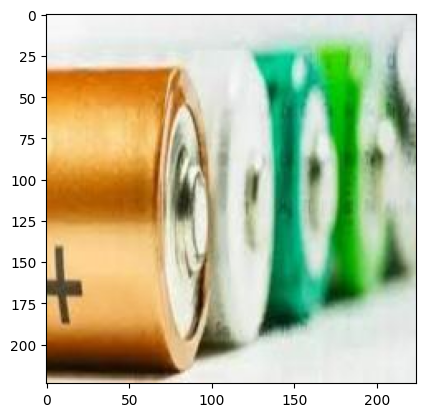

1/1 [==============================] - 0s 23ms/step
Predicted class index: 3
Predicted class name: glass


In [ ]:

#New image path
image_path = "/content/drive/MyDrive/Colab Notebooks/Preprocessed_Images/battery/battery_0123.jpg"
img = image.load_img(image_path, target_size=(224, 224))
plt.imshow(img)
plt.show()
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0
predictions = model.predict(x)
predicted_class = np.argmax(predictions[0])
predicted_class_name = class_labels[predicted_class]
print("Predicted class index:", predicted_class)
print("Predicted class name:", predicted_class_name)

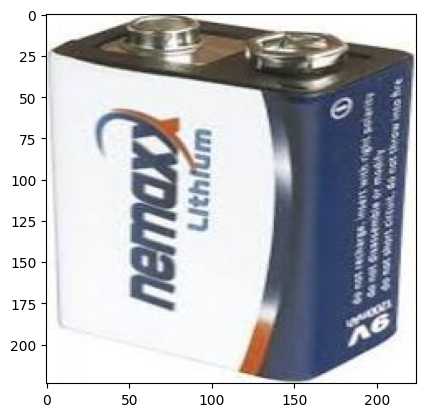

1/1 [==============================] - 0s 32ms/step
Predicted class index: 0
Predicted class name: battery


In [ ]:
#New image path
image_path = "/content/drive/MyDrive/Colab Notebooks/Preprocessed_Images/battery/battery_0113.jpg"
img = image.load_img(image_path, target_size=(224, 224))
plt.imshow(img)
plt.show()
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0
predictions = model.predict(x)
predicted_class = np.argmax(predictions[0])
predicted_class_name = class_labels[predicted_class]
print("Predicted class index:", predicted_class)
print("Predicted class name:", predicted_class_name)

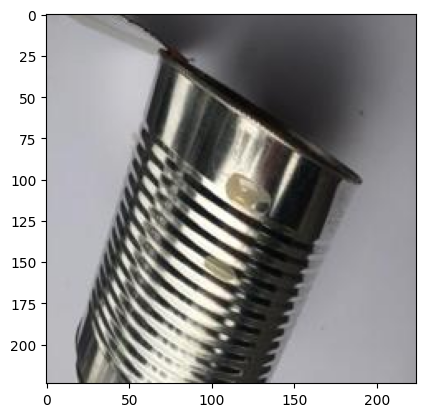

1/1 [==============================] - 0s 22ms/step
Predicted class index: 4
Predicted class name: metal


In [ ]:

#New image path
image_path = "/content/drive/MyDrive/Colab Notebooks/Preprocessed_Images/metal/metal_0032.jpg"
img = image.load_img(image_path, target_size=(224, 224))
plt.imshow(img)
plt.show()
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0
predictions = model.predict(x)
predicted_class = np.argmax(predictions[0])
predicted_class_name = class_labels[predicted_class]
print("Predicted class index:", predicted_class)
print("Predicted class name:", predicted_class_name)

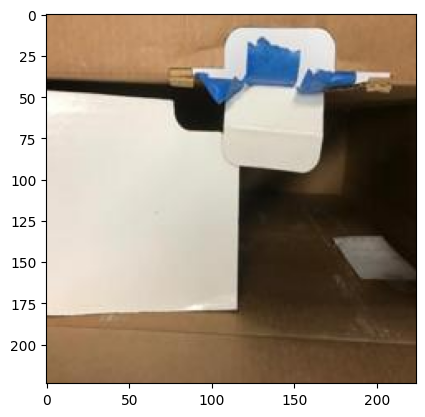

1/1 [==============================] - 0s 25ms/step
Predicted class index: 1
Predicted class name: cardboard


In [ ]:

#New image path
image_path = "/content/drive/MyDrive/Colab Notebooks/Preprocessed_Images/cardboard/cardboard_0042.jpg"
img = image.load_img(image_path, target_size=(224, 224))
plt.imshow(img)
plt.show()
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0
predictions = model.predict(x)
predicted_class = np.argmax(predictions[0])
predicted_class_name = class_labels[predicted_class]
print("Predicted class index:", predicted_class)
print("Predicted class name:", predicted_class_name)

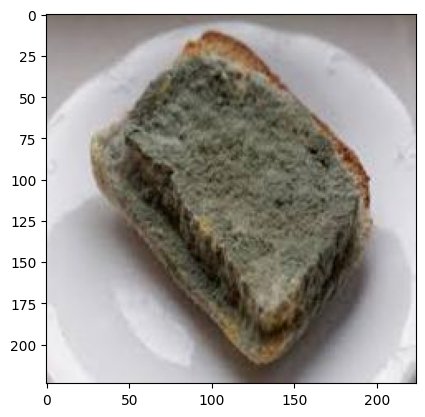

1/1 [==============================] - 0s 56ms/step
Predicted class index: 2
Predicted class name: food_waste


In [ ]:

#New image path
image_path = "/content/drive/MyDrive/Colab Notebooks/Preprocessed_Images/food_waste/food_waste_0007.jpg"
img = image.load_img(image_path, target_size=(224, 224))
plt.imshow(img)
plt.show()
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0
predictions = model.predict(x)
predicted_class = np.argmax(predictions[0])
predicted_class_name = class_labels[predicted_class]
print("Predicted class index:", predicted_class)
print("Predicted class name:", predicted_class_name)

In [ ]:
class_labels

{0: 'battery',
 1: 'cardboard',
 2: 'food_waste',
 3: 'glass',
 4: 'metal',
 5: 'paper',
 6: 'plastic'}

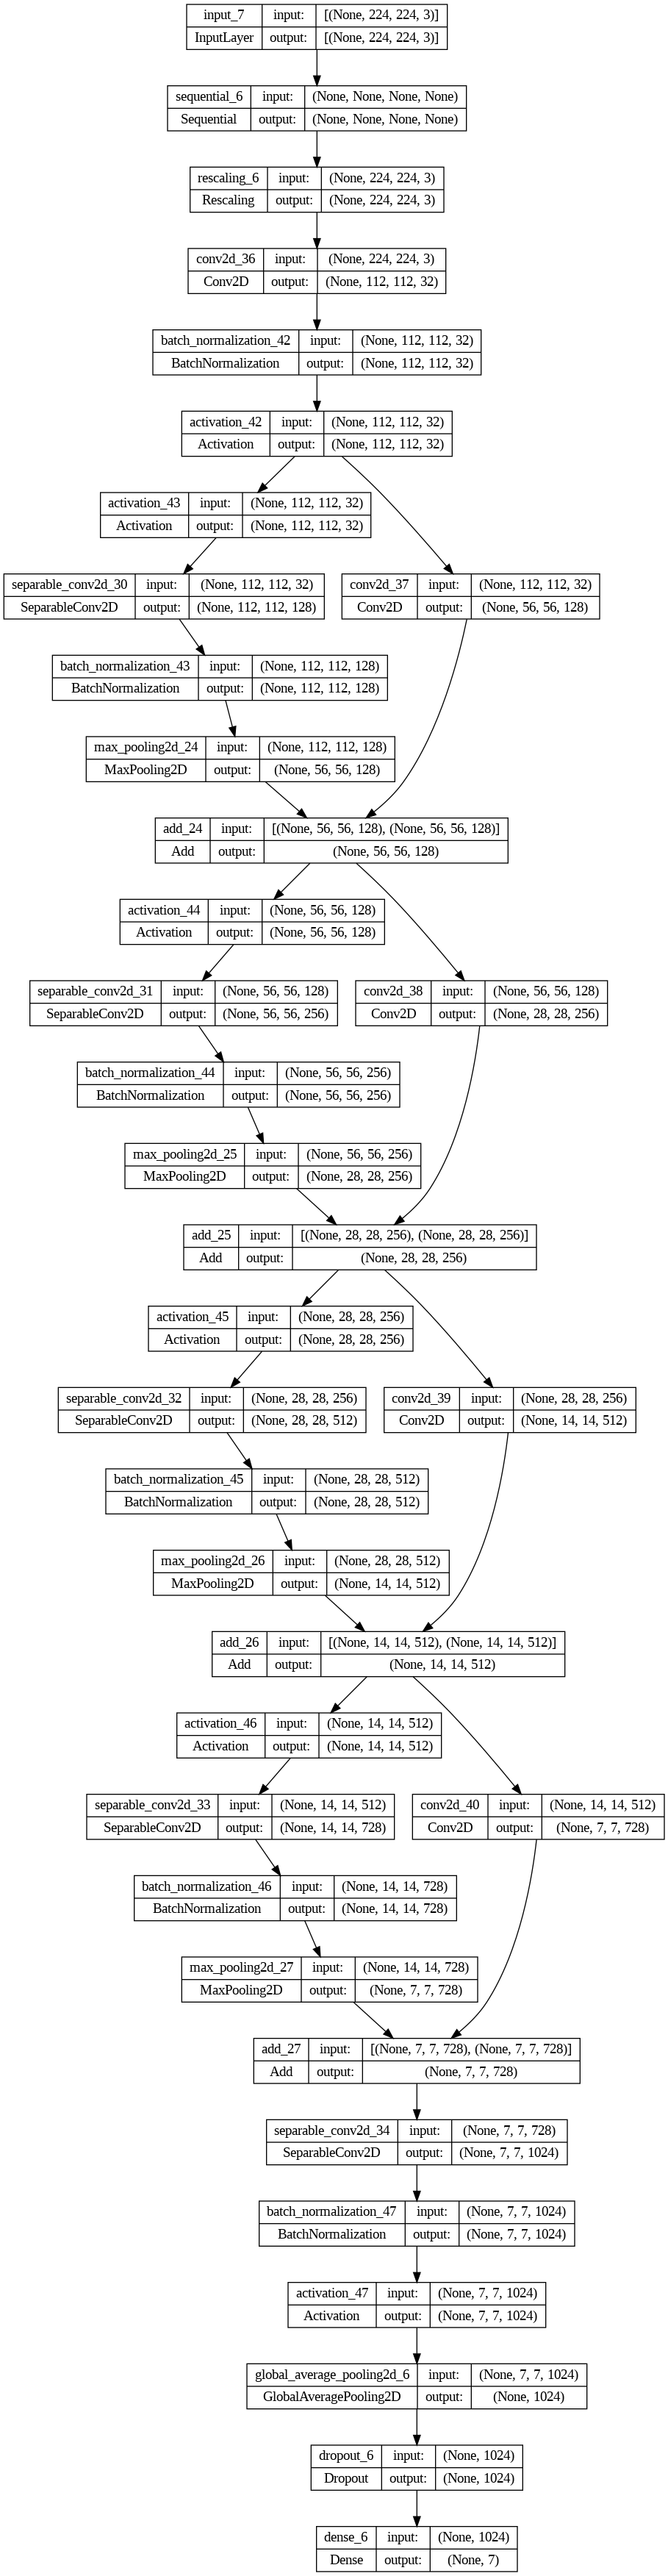

In [ ]:
from keras.utils import plot_model
model = load_model("/content/drive/MyDrive/Colab Notebooks/initial_model_sierra.h5")
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)